# Persistence models

Persistence models (naive models) are simple methods of using past data to forecast futre data points. They are developed to benchmark performance when evaluating more complex methods. This allows us to compare the performance of feature engineering, hyperparameter tuning, and model architecture against a set of references.

#### Persistence Models Evaluated
1. Previous day hour-by-hour
2. Year ago day hour-by-hour

#### Evaluation method

Models are evaluated using root mean squred error (RMSE) in order to be directly comparable to energy readings in the data. RMSE is calculted two ways. First to rebresent the error of predicting each hour at a time (i.e. one error per hourly slice). Second to represent the models overall performance (one value).

Forecasts are produced with a walk forward method. Walk forward makes predictions by moving step wise through the samples making a forecast at each step. After a forecast is made, the test value is added to the end of the training set and reused. 

<img src="img/walk-forward-validation.png" width=600 height=400>


##### Persistence dataset creation

In [11]:
#import required packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style('dark')

from sklearn.metrics import mean_squared_error
#import helper functions
from features_preprocessing import transform_to_windows, rename_cols

In [9]:
#load the preprocessed data
data = pd.read_csv('./data/cleaned_data/energy_loads_2015_2019.csv', parse_dates=True, index_col='time')

#use features preprocessing library to transform data into day and hour slice format.
data = transform_to_windows(data)

#rename the columns
data = rename_cols(data, shift=0)

#fix the data from 2015-2018
data = data['2015':'2018']

#save the dataset as persistance set
data.to_csv('./data/processed/persistence_2015_2018.csv')

#view the dataset and check the slicing
data.head(3)

,t-0 h_0,t-0 h_1,t-0 h_2,t-0 h_3,t-0 h_4,t-0 h_5,t-0 h_6,t-0 h_7,t-0 h_8,t-0 h_9,...,t-0 h_14,t-0 h_15,t-0 h_16,t-0 h_17,t-0 h_18,t-0 h_19,t-0 h_20,t-0 h_21,t-0 h_22,t-0 h_23
date,,,,,,,,,,,,,,,,,,,,,
2015-01-01,25385.0,24382.0,22734.0,21286.0,20264.0,19905.0,20010.0,20377.0,20094.0,20637.0,...,24672.0,23528.0,23118.0,23606.0,26447.0,28020.0,29014.0,29571.0,29031.0,26798.0
2015-01-02,27070.0,24935.0,23214.0,22540.0,22096.0,22066.0,22275.0,23025.0,23699.0,25834.0,...,29241.0,27973.0,27320.0,27157.0,29045.0,31967.0,33266.0,33668.0,32426.0,29705.0
2015-01-03,25564.0,23584.0,22194.0,21296.0,21145.0,21316.0,21674.0,22127.0,22756.0,24654.0,...,26416.0,25362.0,24770.0,24501.0,24992.0,27964.0,29694.0,29874.0,28979.0,26863.0


In [7]:
data.tail(3)

,t-0 h_0,t-0 h_1,t-0 h_2,t-0 h_3,t-0 h_4,t-0 h_5,t-0 h_6,t-0 h_7,t-0 h_8,t-0 h_9,...,t-0 h_14,t-0 h_15,t-0 h_16,t-0 h_17,t-0 h_18,t-0 h_19,t-0 h_20,t-0 h_21,t-0 h_22,t-0 h_23
date,,,,,,,,,,,,,,,,,,,,,
2018-12-29,25709.0,23622.0,22122.0,21368.0,21084.0,21168.0,21927.0,23347.0,24931.0,27300.0,...,28811.0,27815.0,27044.0,27317.0,29535.0,30271.0,30819.0,30718.0,29352.0,27332.0
2018-12-30,24922.0,22772.0,21301.0,20386.0,20103.0,20112.0,20651.0,21639.0,22662.0,24759.0,...,27264.0,26002.0,25313.0,25552.0,28072.0,29221.0,30042.0,30229.0,29145.0,26934.0
2018-12-31,24312.0,22140.0,20851.0,20200.0,20006.0,20366.0,21723.0,23850.0,25969.0,28382.0,...,27988.0,27009.0,26449.0,26738.0,29592.0,30653.0,29735.0,28071.0,25801.0,24455.0


### Previous day hour by hour persistence model

The previous day hour by hour model will use the energy loads from the previous day to forecast the next day on an hour by hour basis. 

|Hour|Current day| --> |Forecast|
|----|-----|----|-----|
|h0  | 450 | -->| 450 |
|h1  | 389 | -->| 389 |
|... | ... | -->| ... |
|h23 | 345 | -->| 345 |

##### Training and test sets
The persistence walk forward validation model uses a walk forward window method as described above.

In [16]:
### define a function to split into training and test sets

def train_test_split(data, size):
    """
    Function takes in dataset where rows are daily values and columns are hourly slices and splits into a train and test.
    
    """
    
    split_size = int(len(data) * size)
    
    train, test = data[:split_size], data[split_size:]
    
    return train, test

##### Calculating forecast errors

In [40]:
def calculate_errors(Y_hat_test, Y_test, result_set):
    
    #set a multi index to store and compare with other models
    columns = [result_set]
    
    error_list = []
    error_mean = []
    
    
    #calculate the mse and mae for each hour in the Y_test and Prediction
    for i in range(Y_hat_test.shape[1]):
        error_list.append([
            #calcualte the RMSE
            np.sqrt(mean_squared_error(Y_hat_test.iloc[:,i], Y_test.iloc[:,i]))
        ])

    #append average mean error of the predictions
    error_mean.append([
        np.mean(error_list[0])
    ])    
    
    
    #set an index with the 24 periods
    index = [str(x) for x in range(24)]
    
    #store errors in dataframe
    errors = pd.DataFrame(error_list, index=index, columns=columns)
    
    return errors, error_mean

###### Walk forward evaluation

In [31]:
def walk_forward_evaluation(model, train, test, model_name):
    """
    Walk forward test harness. Adapted from Machine Learning Mastery by Jason Brownlee.
    
    """
        
    #define the walk forward window. In this case an expanding window for simplicity.
    history = train.copy()

    
    predictions = []
    
    #loop through each row in test from i to length of i
    for i in range(test.shape[0]):
        
        #get forecasted values from the model
        Y_hat = model(history)
        
        #store predictions
        predictions.append(Y_hat)
        
        #get real observation and append to the history for next step in walk forward.
        history.append(test.iloc[i,:])
    
    #store predictions in a dataframe
    predictions = pd.DataFrame(predictions, index = test.index, columns = test.columns)
    
    errors, error_mean = calculate_errors(predictions, test, model_name)
    
    return errors, error_mean

##### Define previous day persistence model

In [26]:
def day_hbh_persistence(history):
    return history.iloc[-1,:]

In [27]:
train, test =train_test_split(data,0.75)

In [41]:
errors, error_mean = walk_forward_evaluation(day_hbh_persistence, train, test, "prev_day_persistence")

In [45]:
def plot_error(errors, result_set=['naive'], title=''):
    """
    Takes a dataframe of errors with headers RMSE, MAE and 24 periods from h_0 to h_23
    
    Returns a plot of the chosen error metric
    
    
    """
    plt.figure(figsize=(8,7))
    
    #get values for the x label
    x_labels = errors.index
    
    for result in result_set:
        #call the plot
        plt.plot(x_labels, errors[result_set])

    #set the label names and title
    plt.ylabel('MWh Error')
    plt.xlabel('Hour of day')
    plt.title(title)
    
    plt.show()

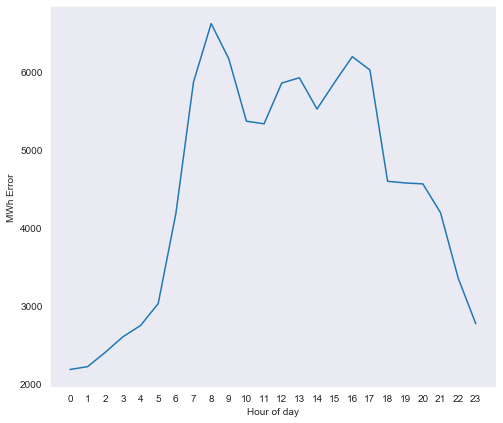

In [47]:
plot_error(errors, result_set=['prev_day_persistence'])

In [ ]:
calculate_errors(Y_hat_test, Y_test, result_set)

In [17]:
train, test =train_test_split(data,0.75)

In [22]:
walk_forward_evaluation(None, train, test)

            t-0 h_0  t-0 h_1  t-0 h_2  t-0 h_3  t-0 h_4  t-0 h_5  t-0 h_6  \
date                                                                        
2015-01-01  25385.0  24382.0  22734.0  21286.0  20264.0  19905.0  20010.0   
2015-01-02  27070.0  24935.0  23214.0  22540.0  22096.0  22066.0  22275.0   
2015-01-03  25564.0  23584.0  22194.0  21296.0  21145.0  21316.0  21674.0   
2015-01-04  25254.0  23620.0  22606.0  22191.0  21929.0  22195.0  24035.0   
2015-01-05  25069.0  23390.0  21988.0  21182.0  20778.0  20309.0  20252.0   
2015-01-06  23711.0  22354.0  21546.0  21171.0  21042.0  21618.0  23433.0   
2015-01-07  30518.0  28484.0  27026.0  26248.0  25838.0  26021.0  26992.0   
2015-01-08  26788.0  25146.0  23889.0  23046.0  22587.0  22361.0  22551.0   
2015-01-09  27485.0  25750.0  24760.0  24188.0  23840.0  24030.0  25965.0   
2015-01-10  24899.0  23505.0  22589.0  22177.0  22025.0  22426.0  24361.0   
2015-01-11  22460.0  21033.0  19977.0  19389.0  19126.0  19199.0  19404.0   

In [14]:
def day_hbh_persistence():
    return None

In [3]:
def set_X_Y_features(data, y_target='t-0', univariate=False):
    """
    Function that takes in the preprocessed data and returns the Y and X datasets for univariate and multivariate test harnesses.
    
    """
    
    #if univariate is called, the function returns the current time step, and the previous time step.
    if univariate:
        y_target='t-0'
        #select the column headers to build Y matrix
        Y_cols = [col for col in data.columns if y_target == col.split()[0]]
        
        x_targets = 't-1'
        #selects the columns headers to build feature vectors of X
        X_cols = [col for col in data.columns if x_targets == col.split()[0]]
    
    #if not univariate then X and Y return the multivariate case with all features
    else:
        #function is incomplete here. following two rows are wrong!!!
        Y_cols = [col for col in data.columns if y_target == col.split()[0]]
        
        X_cols = [col for col in data.columns if y_target == col.split()[0]]
        
    #convert dataframe into numpy array
    Y = np.array(data[Y_cols])
    
    X = np.array(data[X_cols])
    
    return X, Y

In [32]:
X_naive, Y_naive = set_X_Y_features(data, univariate=True)
X_naive.shape, Y_naive.shape

((1066, 24), (1066, 24))

#### Split test and train sets

In [5]:
def split_train_test(X, Y, size):
    """
    Function to split data into train and test sets.
    
    """
    
    train_size = int(len(X) * size)
    
    X_train, X_test = X[:train_size], X[train_size:]
    
    Y_train, Y_test = Y[:train_size], Y[train_size:]
    
    return X_train, X_test, Y_train, Y_test

In [33]:
X_train_naive, X_test_naive, Y_train_naive, Y_test_naive = split_train_test(X_naive, Y_naive, 0.70)

print('X_train shape: {}'.format(X_train_univar.shape))
print('Y_train shape: {}'.format(Y_train_univar.shape))
print('X_test shape: {}'.format(X_test_univar.shape))
print('Y_test shape: {}'.format(Y_test_univar.shape))

X_train shape: (746, 24)
Y_train shape: (746, 24)
X_test shape: (320, 24)
Y_test shape: (320, 24)


### Evaluation metrics

In multi-output problems errors are typically evaluated indivually per output period as opposed to aggregating. Aggregating can still give an indication of the general model performace. Using the indivdual errors however is useful to identify the time steps we are predicting well, versus those that are not.


The base units of the problem are in MWh and having an error metric that is in these same units lets us make a direct comparison. Both Root Mean Squared Error and Mean Absolute Error are suitable for this task.

In [23]:
def calculate_errors(Y_hat_test, Y_test, result_set):
    
    #set a multi index to store and compare with other models
    columns = [[result_set],['RMSE']]
    
    error_list = []
    error_mean = []
    
    
    #calculate the mse and mae for each hour in the Y_test and Prediction
    for i in range(Y_hat_train.shape[1]):
        error_list.append([
            #calcualte the RMSE
            np.sqrt(metrics.mean_squared_error(Y_hat_test[:,i], Y_test[:,i]))
        ])

    #append average mean error of the predictions
    error_mean.append([
        np.mean(error_list[0])
    ])    
    
    
    #set an index with the 24 periods
    index = [str(x) for x in range(24)]
    
    #store errors in dataframe
    errors = pd.DataFrame(error_list, index=index, columns=columns)
    
    return errors, error_mean
    

### Univariate Naive

The univariate naive forecast uses the previous time step as the prediction for the next timestep. As this is a multi-step problem, the naive univariate uses all h0..h23 slices from t-1 as predictions for t.

To calcualte the mean squared and absolute errors for this we will calculate the errors for each of h0...h23 for all time slices in the seires then sum these values. This gives an error for the full 24 hour ahead prediction.

In [35]:
def naive_univariate(X_train, X_test):
    return X_train, X_test
    

In [36]:
Y_hat_train_naive, Y_hat_test_naive = naive_univariate(X_train_univar, X_test_univar)

errors_naive, _ = calculate_errors(Y_hat_test_naive, Y_test_naive, 'naive')
#print(calculate_errors(Y_hat_test, Y_test_univar))
errors_naive

naive             
           RMSE          MAE
0   1754.552024  1284.125000
1   1610.340739  1173.734375
2   1534.230859  1125.228125
3   1534.882443  1160.056250
4   1566.619625  1210.306250
5   1734.748441  1369.821875
6   2688.056995  2048.881250
7   4391.224929  3233.200000
8   5205.568789  3816.178125
9   4924.368032  3659.384375
10  4444.571777  3338.787500
11  4175.399861  3162.128125
12  4287.953124  3217.453125
13  4034.986567  3046.062500
14  3707.768718  2786.243750
15  3979.313719  2989.415625
16  4234.836511  3187.384375
17  4313.269550  3252.312500
18  4137.248289  3102.309375
19  3912.592744  2898.203125
20  3483.699466  2572.575000
21  2934.114203  2181.462500
22  2274.622718  1672.578125
23  1839.509753  1347.650000

Create a function to plot the errors over each timestep

In [43]:
def plot_error(errors, result_set='naive', error_kind='MAE', title='Autoregressive Naive Model'):
    """
    Takes a dataframe of errors with headers RMSE, MAE and 24 periods from h_0 to h_23
    
    Returns a plot of the chosen error metric
    
    
    """
    plt.figure(figsize=(8,7))
    
    #get values for the x label
    x_labels = errors.index
    
    #call the plot
    plt.plot(x_labels, errors[result_set][error_kind])

    #set the label names and title
    plt.ylabel('MWh Error')
    plt.xlabel('Hour of day')
    plt.title(title)
    
    plt.show()

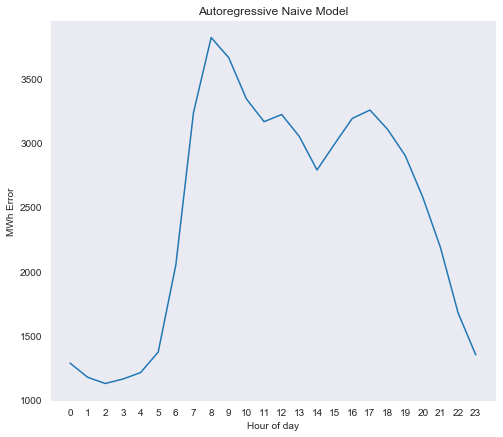

In [39]:
plot_error(errors_naive)

We can see the model does relatively good job predicting from midnight to about 4 am. This makes sense because when considering a typical demand load profile this period is known as the 'base load'. This is the minimum load that grid operators expect to see, and plan to always maintain.

## Moving Average

The moving average forecast uses the moving average from the last t-x steps to predict t. In this example we will investigate moving average of 3, 7, 14 days.

In [45]:
#get the data as X is t-1, and Y is t
X_ma, Y_ma = set_X_Y_features(data, univariate=True)
X_ma.shape, Y_ma.shape

((1066, 24), (1066, 24))

To get an idea what the moving average is doing lets plot the first two months (60 days) of the data along with the moving averages from 3, 7 and 14 days.

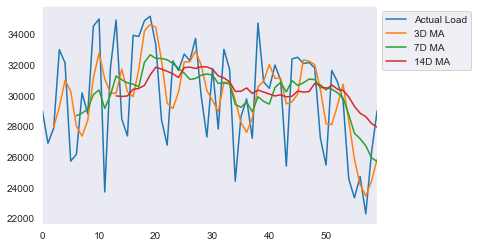

In [75]:
#set interval parmaters
hour= 18
day_start=0
day_end=60

#select data slice
load_range = X_ma.iloc[day_start:day_end,hour]

#plot the original data
load_range.plot(label='Actual Load')

#plot the moving averages
load_range.rolling(3).mean().plot(label='3D MA')
load_range.rolling(7).mean().plot(label='7D MA')
load_range.rolling(14).mean().plot(label='14D MA')

#set the legend location
plt.legend(bbox_to_anchor=(1,1))

We can see how the moving averages 'smooth' out the original data. The shorter the MA window the closer to the original data. The longer the MA window the more it follows the long term trends.

We can now setup a model that uses a moving average to predict t and calcualte the error. 

In [ ]:

X_ma.iloc[:,12].plot()
#X_ma.iloc[12].rolling(3).mean().plot()
#X_ma.iloc[12].rolling(7).mean().plot()
#X_ma.iloc[12].rolling(14).mean().plot()

In [ ]:
#for each hourly timestep construct moving averages form the last x days
def get_moving_averages(X, moving_average=3):
    
    
    
    return None

In [51]:
X_ma = pd.DataFrame(X_ma)

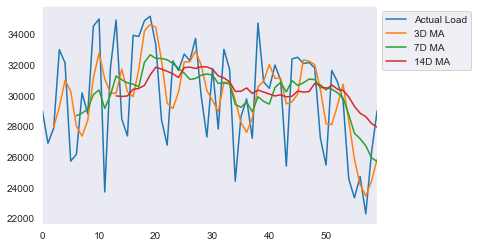

In [74]:
hour= 18
day_start=0
day_end=60

labels = {}

load_range = X_ma.iloc[day_start:day_end,hour]

load_range.plot(label='Actual Load')
load_range.rolling(3).mean().plot(label='3D MA')
load_range.rolling(7).mean().plot(label='7D MA')
load_range.rolling(14).mean().plot(label='14D MA')
plt.legend(bbox_to_anchor=(1,1))

## ARIMA

ARIMA stands for Autoregressive Integrated Moving Average. Compared with the above model it uses a linear combination of past time steps, and moving averages to predict t.

ARIMA takes only a stationary time series. As explored in the ***DATA ANALYSIS*** notebook the load data can be made stationary by ***ANALYSIS RESULTS***

We will use the ARIMA model from statsmodels.api which takes the following arguments:
- p: is the number of lag observations in he model. Lag order.
- d: the number of times raw observations are differenced. Degree of differencing.
- q: the side of the moving average window. The order of moving average.
